In [0]:
rm(list = ls());

#load libraries
library(caret)
library(rpart)
library(rpart.plot)
library(RColorBrewer)
library(rattle)
library(e1071)
library(randomForest)
library(readr)
library(party)					# Alternative decision tree algorithm
library(partykit)				# Convert rpart object to BinaryTree


# set the seed
set.seed(100)


In [16]:
# the url of the files incase you want to read them online 
train.url <- "https://d396qusza40orc.cloudfront.net/predmachlearn/pml-training.csv"
test.url <-  "https://d396qusza40orc.cloudfront.net/predmachlearn/pml-testing.csv"

# read the csv files (saved in hard drive)
train_orig <- read.csv(train.url, header=T)
test_orig <- read.csv(test.url, header=T)

# Drop the first 7 columns as they're unnecessary for predicting.
train_clean <- train_orig[,8:length(colnames(train_orig))]
test_clean <- test_orig[,8:length(colnames(test_orig))]

# Drop colums with NAs
train_clean <- train_clean[, colSums(is.na(train_clean)) == 0] 
test_clean <- test_clean[, colSums(is.na(test_clean)) == 0] 

# Check for near zero variance predictors and drop them if necessary
nzv <- nearZeroVar(train_clean,saveMetrics=TRUE)
zero.var.ind <- sum(nzv$nzv)

# 
if ((zero.var.ind>=0)) {
  train_clean <- train_clean[,nzv$nzv==FALSE]
}

# data partitioning in training set (80%) and validation set (20%) 
train_part <- createDataPartition(train_clean$classe, p=0.80, list=F)
train_final <- train_clean[train_part, ]
validate_final <- train_clean[-train_part, ]

# 5-fold cross-validation performed on Random Forest algorithm
controlPara <- trainControl(method="cv", 5)

# Random Forest for training data set, 300 trees performed 
mod_rf <- train(classe ~ ., data=train_final, method="rf",
                  trControl=controlPara, ntree=300)
# model summary
mod_rf

Random Forest 

15699 samples
   52 predictor
    5 classes: 'A', 'B', 'C', 'D', 'E' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 12558, 12560, 12558, 12561, 12559 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9921653  0.9900887
  27    0.9925476  0.9905725
  52    0.9864966  0.9829188

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 27.

In [0]:
# predict the trained model on validation set
pred_rf <- predict(mod_rf, validate_final)

# confusion matrix on validation set
confusionMatrix(validate_final$classe, pred_rf)

Confusion Matrix and Statistics

          Reference
Prediction    A    B    C    D    E
         A 1114    2    0    0    0
         B    4  755    0    0    0
         C    0    4  678    2    0
         D    0    0    3  640    0
         E    0    0    0    0  721

Overall Statistics
                                          
               Accuracy : 0.9962          
                 95% CI : (0.9937, 0.9979)
    No Information Rate : 0.285           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9952          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: A Class: B Class: C Class: D Class: E
Sensitivity            0.9964   0.9921   0.9956   0.9969   1.0000
Specificity            0.9993   0.9987   0.9981   0.9991   1.0000
Pos Pred Value         0.9982   0.9947   0.9912   0.9953   1.0000
Neg Pred Value         0.9986   0.998

In [0]:
# accuracy of the predicted model
accuracy <- postResample(pred_rf, validate_final$classe)
accu_out <- accuracy[1]
accu_out

Accuracy 
0.9961764

In [0]:
# Overall out of sample error:
OSE <- 1 - as.numeric(confusionMatrix(validate_final$classe, pred_rf)
                 $overall[1])
OSE

[1] 0.003823604

In [0]:
# trained model applied to test data for results
pred_test <- predict(mod_rf, test_clean[, -length(names(test_clean))])
pred_test

[1] B A B A A E D B A A B C B A E E A B B B
Levels: A B C D E

integer(0)

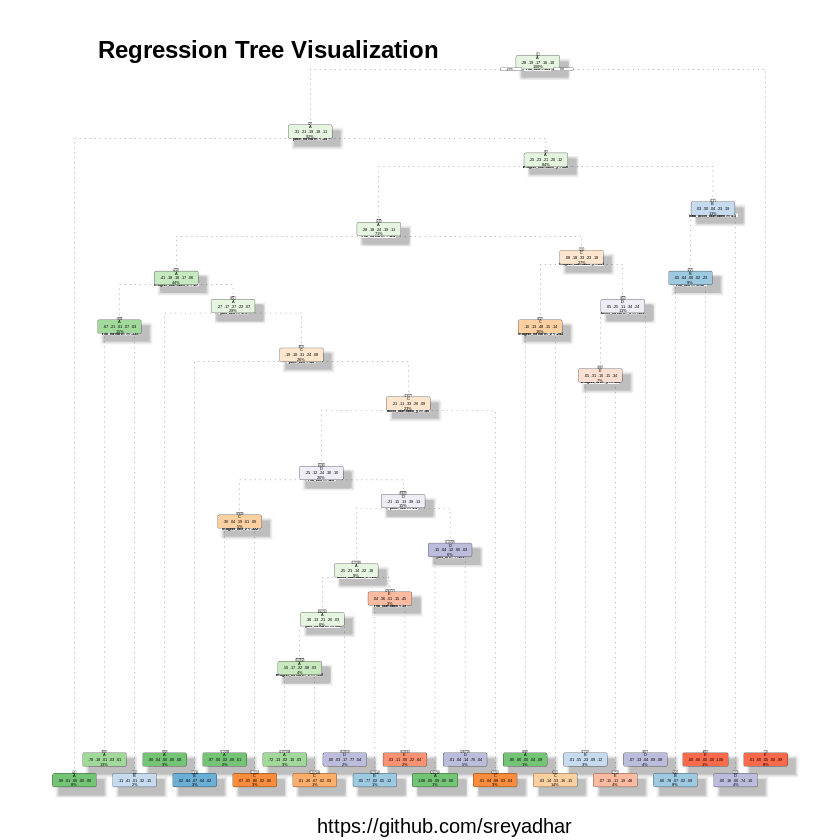

In [0]:
# Building the regression tree
mytree <- rpart(classe ~ ., data=train_final, method="class")

# Plot the tree 
fancyRpartPlot(mytree, caption = 'https://github.com/sreyadhar') +
title('Regression Tree Visualization',adj = 0.0)